## Docs

In [1]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sparse
import warnings 
from scipy import integrate
import seaborn as sns
warnings.simplefilter('ignore')
from sklearn.decomposition import PCA
import scipy.io as sio
from tqdm.auto import tqdm
import importlib

sns.set_style('white')
# to change default color cycle
cs = ['#0D7BBF', '#716568', '#EE922F', '#E6E4C1', '#BCC2C3', '#4D7399', '#CDBCA5']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

from pyaldata import *
import rutils
from rutils import *

importlib.reload(rutils);

### Load session data

In [2]:
'''
Insert path and filename 
'''
path = '/Users/Daphne/Data/'  
fname = 'Chewie_CO_VR_2016-10-06.mat' 
df = mat2dataframe(path+fname, shift_idx_fields=True)


---

> `read_cmp()`

The `.cmp` file contains the location of the electrodes on the array.

We want to know the spatial location of electrodes so that we know the spatial location of the recorded neurons.

Note that, while an array is a 10x10 grid, there are only 96 electrodes on a given array due to hardware constraints. 

By default, omitted electrodes (dead electrodes) are the 4 corner grids. If something goes wrong during fabrication however, this may change.

---

In [3]:
df_m1_arr = read_cmp('/Users/Daphne/Desktop/Chewie Left M1 SN 6250-001474.cmp')
df_pmd_arr = read_cmp('/Users/Daphne/Desktop/Chewie Left PMd SN 6251-001469.cmp')

In [4]:
df_m1_arr.head()

,array_col,array_row,channel_num,within_channel_num,global_enum
0,0,8,C,1,96
1,0,7,C,3,95
2,0,6,C,5,94
3,0,5,C,7,93
4,0,4,C,9,92


---

> `localize_elecs()`

Get the spatial location of electrodes on the array. Set `verbose=True` to visualise the array.

---

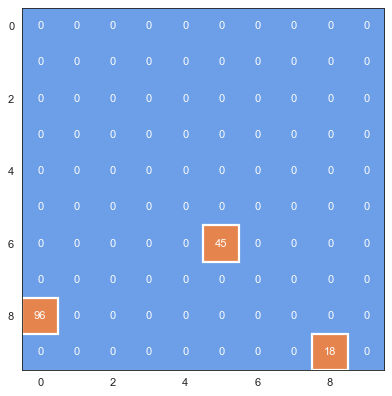

In [5]:
localize_elecs(df_m1_arr, elecs=[96, 18, 45], verbose=True);

For the M1 array, we see that indeed all corner squares are omitted.

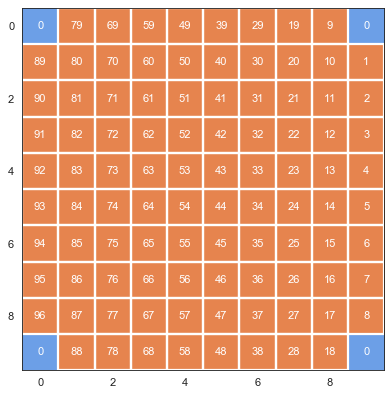

In [6]:
localize_elecs(df_m1_arr, elecs=range(1,97), verbose=True);

For the PMd array one dead electrode has a different location.

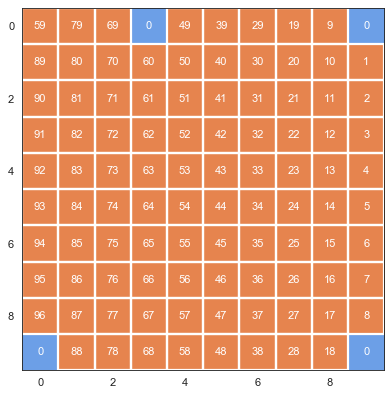

In [7]:
localize_elecs(df_pmd_arr, elecs=range(1,97), verbose=True);

The colored grids are just for visualisation purposes, we can use the np arrays to continue.

We have the spatial location of each electrode and we have **unit guides** that specify how many neurons each electrode covers.

Connecting these two, we can get the spatial location of $n$ neurons on the array.

In [8]:
m1_elecmap  = localize_elecs(df_m1_arr, elecs=range(1,97))
pmd_elecmap = localize_elecs(df_pmd_arr, elecs=range(1,97))

In [9]:
pmd_elecmap

array([[59., 79., 69.,  0., 49., 39., 29., 19.,  9.,  0.],
       [89., 80., 70., 60., 50., 40., 30., 20., 10.,  1.],
       [90., 81., 71., 61., 51., 41., 31., 21., 11.,  2.],
       [91., 82., 72., 62., 52., 42., 32., 22., 12.,  3.],
       [92., 83., 73., 63., 53., 43., 33., 23., 13.,  4.],
       [93., 84., 74., 64., 54., 44., 34., 24., 14.,  5.],
       [94., 85., 75., 65., 55., 45., 35., 25., 15.,  6.],
       [95., 86., 76., 66., 56., 46., 36., 26., 16.,  7.],
       [96., 87., 77., 67., 57., 47., 37., 27., 17.,  8.],
       [ 0., 88., 78., 68., 58., 48., 38., 28., 18.,  0.]])

---

> `elecs_to_neurons()` 

provides a mapping between each electrode number and the number of cells to that electrode

---

In [10]:
m1_cell_distrib, m1_cells_on_arr = elecs_to_neurons(m1_elecmap, df['M1_unit_guide'][0])

pmd_cell_distrib, pmd_cells_on_arr = elecs_to_neurons(pmd_elecmap, df['PMd_unit_guide'][0])

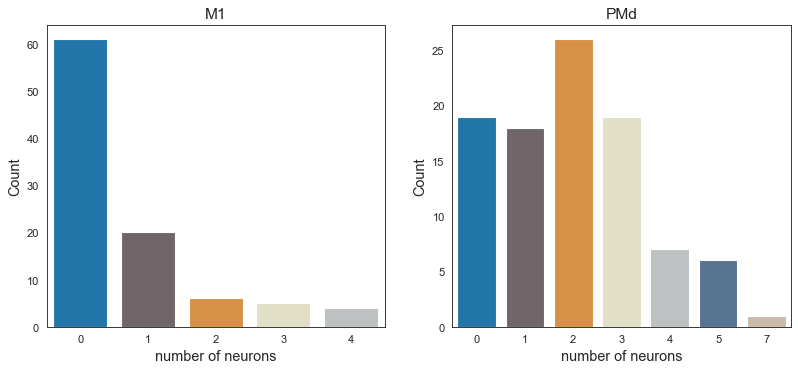

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), dpi=80)

sns.countplot(x=m1_cell_distrib, ax=ax1)
ax1.set_title('M1', fontsize=14)
ax1.set_xlabel('number of neurons', fontsize=13)
ax1.set_ylabel('Count', fontsize=13)

sns.countplot(x=pmd_cell_distrib, ax=ax2)
ax2.set_title('PMd', fontsize=14)
ax2.set_xlabel('number of neurons', fontsize=13)
ax2.set_ylabel('Count', fontsize=13);

---

> `display_grid()` 

just a simple function that displays the array as an annotates grid

---

Total number of neurons on the M1 array is 63


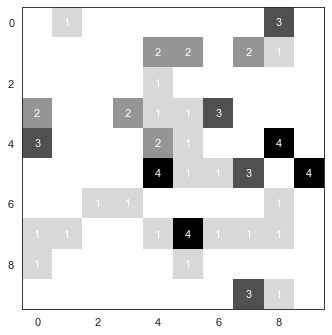

In [12]:
print(f'Total number of neurons on the M1 array is {sum(m1_cell_distrib)}')

display_grid(m1_cells_on_arr)

Total number of neurons on the PMd array is 192


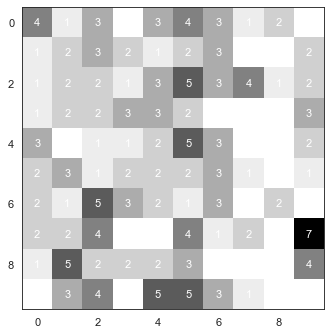

In [13]:
print(f'Total number of neurons on the PMd array is {sum(pmd_cell_distrib)}')

display_grid(pmd_cells_on_arr)

---

> `make_raster()` 

makes a raster plot given a set of spike trains

---

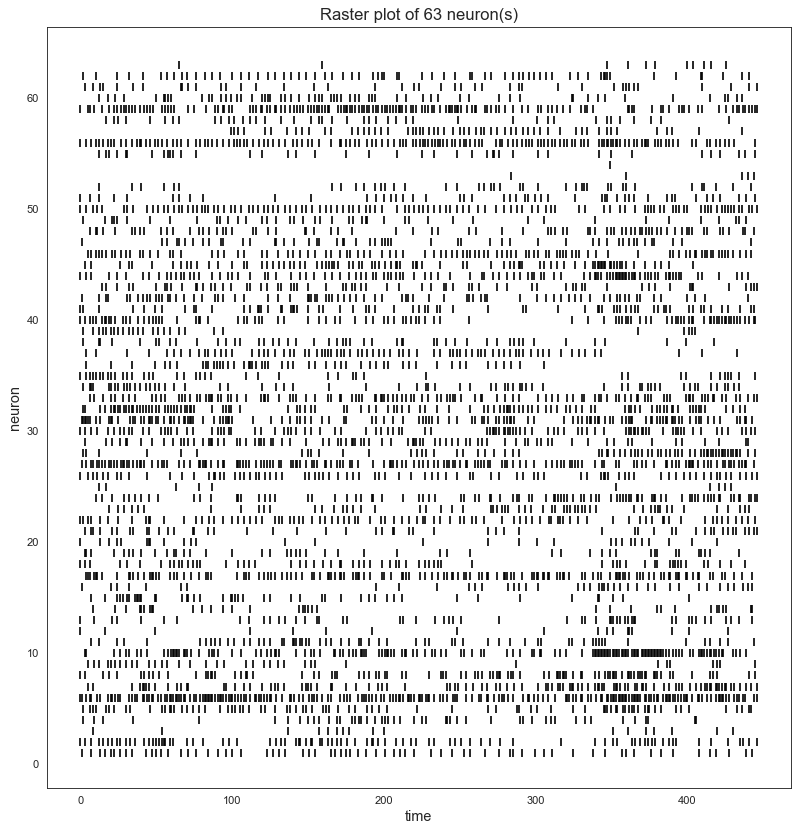

In [14]:
make_raster(df['M1_spikes'][0])

The unit guides specify the number of neurons per electrode. 

```
[electrode k, neuron 1]
[electrode k, neuron 2]
[electrode k, neuron 3]
[electrode k+1, neuron 1]
etc.
```

While the unit guides are `(774 x N)` (we have a unit guide for each row), they are all equal.

So we can pick an arbitrary row. 

In [15]:
unit_guide = df['M1_unit_guide'][0]

df_flat = pd.DataFrame(columns=['electrode', 'neuron', 'trial', 'spikes'])

for i, row in enumerate(unit_guide):
    e, n = row
    df_app = pd.DataFrame(columns=['trial', 'spikes'])
    for tr in range(df.shape[0]):
        df_app = df_app.append({
            'trial' : tr,
            'spikes' : df['M1_spikes'][tr][:, i]
        }, ignore_index=True)
    df_app['electrode'] = e
    df_app['neuron'] = n
    df_flat = df_flat.append(df_app, ignore_index=True)
    
df_flat = df_flat.loc[:, ['electrode', 'neuron', 'trial', 'spikes']]

In [16]:
df_flat

,electrode,neuron,trial,spikes
0,5,1,0,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
1,5,1,1,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, ..."
2,5,1,2,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ..."
3,5,1,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,5,1,4,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...
48757,96,1,769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
48758,96,1,770,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
48759,96,1,771,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
48760,96,1,772,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
